# 1-MNIST手写数字识别(全连接)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.callbacks as tfcb
import PIL.ImageOps

In [2]:
%matplotlib inline 

## Load Dataset

In [3]:
(ds_train, ds_test), ds_info = tfds.load('mnist', split=['train', 'test'],
                                         as_supervised=True,
                                         with_info=True)

## Show Dataset Info 

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/xubinni/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

## Show a sample Data

size:(28, 28, 1),max:255,min:0
label:4


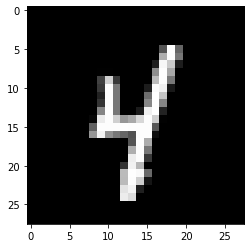

In [5]:
for element in ds_train.as_numpy_iterator():
    sample_data, sample_label = element
    break

print("size:{},max:{},min:{}".format(sample_data.shape,
                                     np.max(sample_data),
                                     np.min(sample_data)))
print("label:{}".format(sample_label))
plt.imshow(sample_data, interpolation='nearest', cmap="gray")
plt.show()

In [6]:
IMG_HEIGHT = 28
IMG_WIDTH = 28

## Normalize
因为数据集的值的范围是0～255，所以需要归一化一下。

In [7]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

size:(28, 28, 1),max:1.0,min:0.0


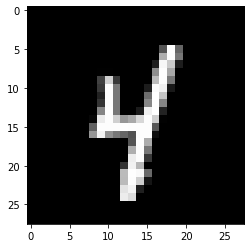

In [8]:
nor_sample_data, _ = normalize_img(sample_data, sample_label)
print("size:{},max:{},min:{}".format(nor_sample_data.shape,
                                     np.max(nor_sample_data),
                                     np.min(nor_sample_data)))
plt.imshow(nor_sample_data, interpolation='nearest', cmap="gray")
plt.show()

## Build Input Pipeline

In [9]:
ds_train = ds_train.map(normalize_img,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                        .cache()\
                        .shuffle(ds_info.splits['train'].num_examples)\
                        .batch(128)\
                        .prefetch(tf.data.experimental.AUTOTUNE)

In [10]:
ds_test = ds_test.map(normalize_img,
                      num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                    .batch(128)\
                    .cache()\
                    .prefetch(tf.data.experimental.AUTOTUNE)

## Build Model

In [11]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

## Compile Model

In [12]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

## Train

In [13]:
history = tfcb.History()
model.fit(
    ds_train,
    epochs=60,
    validation_data=ds_test,
    callbacks=[history]
)

Epoch 1/60
469/469 [==============================] - 3s 3ms/step - loss: 0.6142 - sparse_categorical_accuracy: 0.8332 - val_loss: 0.1912 - val_sparse_categorical_accuracy: 0.9477
Epoch 2/60
469/469 [==============================] - 1s 1ms/step - loss: 0.1723 - sparse_categorical_accuracy: 0.9508 - val_loss: 0.1339 - val_sparse_categorical_accuracy: 0.9603
Epoch 3/60
469/469 [==============================] - 1s 1ms/step - loss: 0.1220 - sparse_categorical_accuracy: 0.9651 - val_loss: 0.1115 - val_sparse_categorical_accuracy: 0.9653
Epoch 4/60
469/469 [==============================] - 1s 1ms/step - loss: 0.0908 - sparse_categorical_accuracy: 0.9747 - val_loss: 0.0942 - val_sparse_categorical_accuracy: 0.9708
Epoch 5/60
469/469 [==============================] - 1s 1ms/step - loss: 0.0740 - sparse_categorical_accuracy: 0.9780 - val_loss: 0.0859 - val_sparse_categorical_accuracy: 0.9738
Epoch 6/60
469/469 [==============================] - 1s 1ms/step - loss: 0.0574 - sparse_categorica

## Visualize Training Result

In [14]:
def show_history(history):
    train_loss = history.history['loss']
    train_acc = history.history['sparse_categorical_accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_sparse_categorical_accuracy']

    t = np.arange(0, len(train_loss), 1)
    fig, axs = plt.subplots(2, 1)

    color = 'tab:red'
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('train_loss', color=color)
    axs[0].plot(t, train_loss, color=color)
    axs[0].tick_params(axis='y', labelcolor=color)

    ax12 = axs[0].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax12.set_ylabel('train_acc', color=color)  # we already handled the x-label with ax1
    ax12.plot(t, train_acc, color=color)
    ax12.tick_params(axis='y', labelcolor=color)

    color = 'tab:red'
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('val_loss', color=color)
    axs[1].plot(t, val_loss, color=color)
    axs[1].tick_params(axis='y', labelcolor=color)

    ax22 = axs[1].twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax22.set_ylabel('val_acc', color=color)  # we already handled the x-label with ax1
    ax22.plot(t, val_acc, color=color)
    ax22.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()

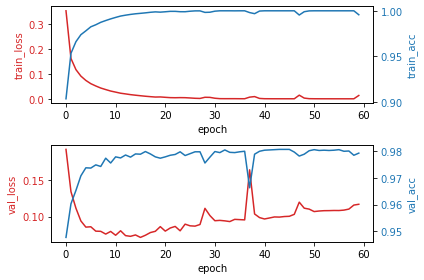

In [15]:
show_history(history)

其实可以看出，10个epoch后就开始过拟合了。

## 添加Dropout层
减少过拟合

In [16]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10)
])

model2.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

history2 = tfcb.History()
model2.fit(
    ds_train,
    epochs=60,
    validation_data=ds_test,
    callbacks=[history2]
)

Epoch 1/60
469/469 [==============================] - 1s 2ms/step - loss: 0.7329 - sparse_categorical_accuracy: 0.7820 - val_loss: 0.2098 - val_sparse_categorical_accuracy: 0.9397
Epoch 2/60
469/469 [==============================] - 1s 1ms/step - loss: 0.2586 - sparse_categorical_accuracy: 0.9228 - val_loss: 0.1486 - val_sparse_categorical_accuracy: 0.9566
Epoch 3/60
469/469 [==============================] - 1s 2ms/step - loss: 0.1919 - sparse_categorical_accuracy: 0.9415 - val_loss: 0.1195 - val_sparse_categorical_accuracy: 0.9635
Epoch 4/60
469/469 [==============================] - 1s 1ms/step - loss: 0.1558 - sparse_categorical_accuracy: 0.9524 - val_loss: 0.1052 - val_sparse_categorical_accuracy: 0.9680
Epoch 5/60
469/469 [==============================] - 1s 2ms/step - loss: 0.1403 - sparse_categorical_accuracy: 0.9570 - val_loss: 0.0900 - val_sparse_categorical_accuracy: 0.9731
Epoch 6/60
469/469 [==============================] - 1s 1ms/step - loss: 0.1280 - sparse_categorica

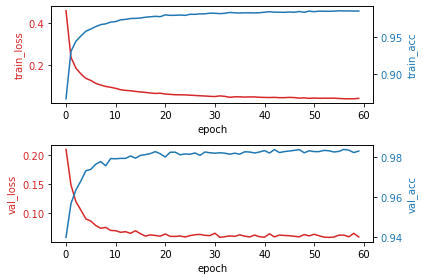

In [17]:
show_history(history2)

## 拿张图片试试
我们从网上找一个数据集之外的图片看看

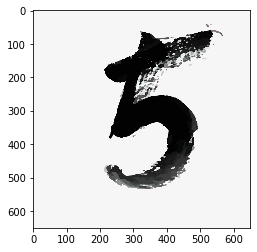

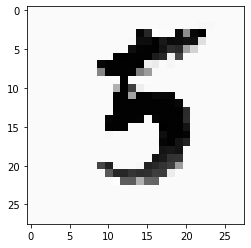

In [18]:
sunflower_url = "https://gimg2.baidu.com/image_search/src=http%3A%2F%2Fbpic.588ku.com%2Felement_origin_min_pic%2F18%2F06%2F09%2F45fb84189924b2e6695f494ab9e2df89.jpg&refer=http%3A%2F%2Fbpic.588ku.com&app=2002&size=f9999,10000&q=a80&n=0&g=0n&fmt=jpeg?sec=1615431034&t=3c1aaed9443c89ef8594d689eac0e5bc"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img_origin = tf.keras.preprocessing.image.load_img(
    sunflower_path
)
plt.imshow(img_origin, interpolation='nearest')
plt.show()


img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale"
)
plt.imshow(img, interpolation='nearest', cmap="gray")
plt.show()

需要注意的是，这里的格式和我们的训练集是完全相反的，训练集的数字主体是非0值（白色），背景是0（黑色）。虽然我们人一眼就能看出这是5（因为黑色白色对我们没影响，我们是根据空间结构判断的），但是对于机器来说这个input的特征和训练时遇到的5基本没啥相似点，很大可能会识别为别的数字（我试了，它认为这个是铁7）。所以我们需要对这个图片预处理一下，让其符合我们模型的输入分布。

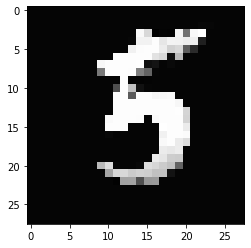

In [19]:
img_fixed = PIL.ImageOps.invert(img)
plt.imshow(img_fixed, interpolation='nearest', cmap="gray")
plt.show()

是骡子是马，拉出来溜溜！

In [20]:
img_array = tf.keras.preprocessing.image.img_to_array(img_fixed)
img_array = tf.expand_dims(img_array, 0) # Create a batch
predictions = model2.predict(img_array)
score = tf.nn.softmax(predictions[0])
class_names = list(range(10))
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to 5 with a 100.00 percent confidence.


✌️